In [1]:
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [4]:
from sklearn.metrics import mean_squared_error, median_absolute_error,mean_absolute_error

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data= pd.read_csv('data_part2.csv')

In [9]:
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,BuildingAge,Steam%,Electricity%,NaturalGas%,OtherEnergies%
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,0,88434,65.0,6981428.0,249.43,88,28.977338,52.799513,18.225326,-0.002177
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,15064,88502,51.0,8354235.0,263.51,19,0.000000,46.747679,53.254248,-0.001927
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,0,961990,18.0,73130656.0,2061.48,46,26.883943,68.045930,5.072975,-0.002848
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,0,61320,1.0,28229320.0,1936.34,89,83.099834,9.809032,7.091542,-0.000407
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,12460,107430,67.0,14829099.0,507.70,35,0.000000,40.907711,59.093981,-0.001693


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258 entries, 0 to 3257
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BuildingType         3258 non-null   object 
 1   PrimaryPropertyType  3258 non-null   object 
 2   Neighborhood         3258 non-null   object 
 3   NumberofBuildings    3258 non-null   float64
 4   NumberofFloors       3250 non-null   float64
 5   PropertyGFAParking   3258 non-null   int64  
 6   PropertyGFABuilding  3258 non-null   int64  
 7   ENERGYSTARScore      2174 non-null   float64
 8   SiteEnergyUse        3258 non-null   float64
 9   TotalGHGEmissions    3258 non-null   float64
 10  BuildingAge          3258 non-null   int64  
 11  Steam%               3240 non-null   float64
 12  Electricity%         3247 non-null   float64
 13  NaturalGas%          3244 non-null   float64
 14  OtherEnergies%       3240 non-null   float64
dtypes: float64(9), int64(3), object(3)
mem

## Preprocessing

Transformation logarithmiques des variables à prédire

In [11]:
data.loc[:, ["SiteEnergyUse", "TotalGHGEmissions"]] = data.loc[:, ["SiteEnergyUse", "TotalGHGEmissions"]].apply(lambda x: np.log(1 + x))

### SiteEnergyUse

#### Imputation, standardisation et encodage avec pipeline

In [12]:
data['Electricity%'].value_counts()

100.000000    48
inf            7
0.000000       2
58.886405      1
62.279759      1
              ..
99.999942      1
69.739404      1
46.904669      1
77.135793      1
100.004168     1
Name: Electricity%, Length: 3193, dtype: int64

In [13]:
data['NaturalGas%'].value_counts()

0.000000     911
inf            4
18.034608      1
2.910861       1
6.289938       1
            ... 
23.332043      1
55.593379      1
51.981035      1
0.384838       1
3.512446       1
Name: NaturalGas%, Length: 2331, dtype: int64

In [14]:
data[data==np.inf]=np.nan

In [15]:
# split "SiteEnergyUse" et "SiteEnergyUse" into train test sets
X= data.drop(columns=['TotalGHGEmissions','SiteEnergyUse'], axis=1)
y_energy = data['SiteEnergyUse']
y_co2= data['TotalGHGEmissions']

X_train, X_test, y_train_energy, y_test_energy = train_test_split(X,y_energy, test_size=0.2, random_state=34)

# traitement des variables discrete 
numeric_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['PropertyGFAParking','PropertyGFABuilding','Steam%','Electricity%',
                        'NaturalGas%', 'OtherEnergies%']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('num_log', numeric_log_transformer, numeric_log_features),
                                               ('cat', categorical_transformer, categorical_features)])

              
from sklearn import set_config 
set_config(display='diagram')

preprocessor.fit(X_train, y_train_energy)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'ENERGYSTARScore', 'BuildingAge']),
                                ('num_log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log', FunctionTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['PropertyGFAParking', 'PropertyGFABuilding',
                                  'Steam%', 'Electricity%', 'NaturalGas%',
                                  'OtherEnergies%']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood'])])

In [16]:
X_test.head(5)

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding,ENERGYSTARScore,BuildingAge,Steam%,Electricity%,NaturalGas%,OtherEnergies%
1779,SPS-District K-12,K-12 School,LAKE UNION,1.0,4.0,0,241066,79.0,19,0.0,39.737334,60.262666,0.000000
2071,NonResidential,Mixed Use Property,GREATER DUWAMISH,1.0,3.0,0,56700,37.0,106,0.0,86.247156,13.752844,0.000000
1037,NonResidential,Warehouse,MAGNOLIA / QUEEN ANNE,1.0,2.0,0,39497,8.0,60,0.0,76.070681,23.932494,-0.003175
2004,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,1.0,1.0,0,53250,96.0,52,0.0,58.420491,41.579495,0.000014
2421,NonResidential,Warehouse,GREATER DUWAMISH,1.0,1.0,0,27680,NaN,48,0.0,36.122837,63.877177,-0.000014


In [156]:
# feature_importances_names

array(['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore',
       'BuildingAge', 'PropertyGFAParking', 'PropertyGFABuilding',
       'Steam%', 'Electricity%', 'NaturalGas%', 'OtherEnergies%',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_College/University',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Commun

In [160]:
pip= Pipeline(steps=[('preprocessor', preprocessor)])
# pour s'assurer que ça marche, on voit bien que les données ont été transformées, donc le step du preprocessor marche
pd.DataFrame.sparse.from_spmatrix(pip['preprocessor'].transform(X_test)).head(5)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-0.310673,0.806312,-1.060356,-0.068398,-0.021942,-0.234155,-1.177855,1.263946,-0.044316,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.310673,-0.252565,1.585539,-0.068398,-0.171240,-0.234155,0.609325,-0.519854,-0.044316,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.310673,-0.351368,0.186560,-0.068398,-0.320537,-0.234155,0.218285,-0.129432,-0.045330,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.310673,-0.272380,-0.056741,-0.068398,-0.469835,-0.234155,-0.459939,0.547387,-0.044312,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.310673,-0.419237,-0.178391,-0.068398,-0.469835,-0.234155,-1.316745,1.402574,-0.044321,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print(X_train.shape, y_train_energy.shape)
print(X_test.shape, y_test_energy.shape)

(2606, 13) (2606,)
(652, 13) (652,)


### Sélection et entrainement de modèles

#### RandomForestRegressor

In [17]:
# RandomForestRegressor
pipe_RFR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(RandomForestRegressor()))])

param_RFR = {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__regressor__max_features' : ['sqrt', 'log2'],
             'model__regressor__n_estimators':[100,250],
             'model__regressor__max_depth':[5,10,15],
             'model__regressor__min_samples_split': [2, 5, 10],
             'model__regressor__bootstrap' : [True, False],
             'model__regressor__min_samples_leaf': [1,2,5],
             'model__regressor__n_jobs': [-1]}

grid_RFR = GridSearchCV( pipe_RFR, param_RFR,cv=4, verbose=5)
grid_RFR.fit(X_train, y_train_energy)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   3.6s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=Tru

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bo

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__bo

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   1.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor_

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__r

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor_

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__re

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__r

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__bo

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, mo

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, mo

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, mo

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor_

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, mode

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, mode

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor_

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regress

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regres

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__boot

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regress

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=False

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regre

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regres

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.6s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.7s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.6s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__boot

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regress

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regre

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regres

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
             param_grid={'model__regressor__bootstrap': [True, False],
                         'model__regressor__max_depth': [5, 10, 15],
                         'model__regressor__max_features': ['sqrt', 'log2'],
                         'model__regressor__min_samples_leaf': [1, 2, 5],
                         'model__regressor__min_samples_split': [2, 5, 10],
                         'model__regressor__n_estimators': [100, 250],
                         'model__regressor__n_jobs': [-1],
                         'preprocessor__num_log__log__func': [None,
                                                              <ufunc 'log1p'>]},
             verbose=5)

In [18]:
grid_RFR.best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_depth': 15,
 'model__regressor__max_features': 'sqrt',
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 2,
 'model__regressor__n_estimators': 100,
 'model__regressor__n_jobs': -1,
 'preprocessor__num_log__log__func': None}

In [19]:
# RandomForestRegressor best params
RFR_energy = Pipeline(steps=[('preprocessor', preprocessor),
                ('model',TransformedTargetRegressor(regressor= RandomForestRegressor(bootstrap= False,
                  max_depth= 15, max_features= 'sqrt', min_samples_leaf= 1,min_samples_split= 2,
                  n_estimators = 100, n_jobs= -1  )))])
RFR_energy_fit = RFR_energy.fit(X_train, y_train_energy)
RFR_energy_Score= RFR_energy.score(X_test, y_test_energy)

In [20]:
RFR_energy_Score

0.6575271375117877

In [151]:
print("score d'entrainement = ",RFR_energy_Score,"\n")
y_pred_energy = RFR_energy_fit.predict(X_test)
MAE_RFR_en= mean_absolute_error(y_test_energy,y_pred_energy)
RMSE_RFR_en = mean_squared_error(y_test_energy,y_pred_energy , squared= False)
MSE_RFR_en = mean_squared_error(y_test_energy,y_pred_energy)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_RFR_en)
print("RMSE = ",RMSE_RFR_en)
print("MSE = ",MSE_RFR_en)

score d'entrainement =  0.6575271375117877 

score de la prédiction:
MAE =  0.46699582800953665
RMSE =  1.031769618498539
MSE =  1.0645485456566206


In [22]:
# Temp d'entrainement du modèle
best_model_index = grid_RFR.best_index_
    
gs_RFR_mean_time_en= grid_RFR.cv_results_['mean_fit_time'][best_model_index]
gs_RFR_std_time_en= grid_RFR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_RFR_mean_time_en)
print("std_time = ",gs_RFR_std_time_en)

mean_time =  0.29335397481918335
std_time =  0.006382931055274024


### GradientBoostingRegressor

In [23]:
# GradientBoostingRegressor
pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(GradientBoostingRegressor()))])
   
grid_gbr = [{'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[np.log],
             'model__inverse_func':[np.exp],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]},
            {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[None],
             'model__inverse_func':[None],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]}
            ]

gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=4,
                      verbose=5)

gs_gbr.fit(X_train, y_train_energy)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model_

[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=

[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__in

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inver

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   6.0s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   6.1s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   7.3s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   7.6s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.4s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.2s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   6.0s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   7.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   8.6s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   8.3s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.7s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   5.9s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   7.7s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.3s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.4s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.6s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regress

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                                               <ufunc 'log1p'>]},
                         {'model__func': [None], 'model__inverse_func': [None],
                          'model__regressor__learning_rate': [0.16, 0.18, 0.2],
                          'model__regressor__max_depth': [4],
                          'model__regressor__n_estimators': array([1200, 1500, 1800]),
                          'model__regressor__random_state': [1],
                          'model__regressor__subsample': [0.7, 0.8, 0.9],
                          'preprocessor__num_log__log__func': [None,
                                                               <ufunc 'log1p'>]}],
             verbose=5)

In [24]:
gs_gbr.best_params_

{'model__func': None,
 'model__inverse_func': None,
 'model__regressor__learning_rate': 0.18,
 'model__regressor__max_depth': 4,
 'model__regressor__n_estimators': 1800,
 'model__regressor__random_state': 1,
 'model__regressor__subsample': 0.8,
 'preprocessor__num_log__log__func': None}

In [25]:
# GradientBoostingRegressor best params
GBR_energy= Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', GradientBoostingRegressor(n_estimators=1800, learning_rate=0.18,
                                      max_depth=4, subsample=0.8, random_state=1))])

GBR_energy_fit= GBR_energy.fit(X_train, y_train_energy)
GBR_energy_Score= GBR_energy.score(X_test, y_test_energy)

In [150]:
print("score d'entrainement = ",GBR_energy_Score,"\n")
y_pred_energy = GBR_energy.predict(X_test)
MAE_gbr_en= mean_absolute_error(y_test_energy,y_pred_energy)
RMSE_gbr_en = np.sqrt(mean_squared_error(y_test_energy,y_pred_energy))
MSE_gbr_en = mean_squared_error(y_test_energy,y_pred_energy)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_gbr_en)
print("RMSE = ",RMSE_gbr_en)
print("MSE = ",MSE_gbr_en)

score d'entrainement =  0.8289569844627129 

score de la prédiction:
MAE =  0.3692850488648082
RMSE =  0.7291591432007107
MSE =  0.5316730561131946


In [27]:
# Temp d'entrainement du modèle
best_model_index = gs_gbr.best_index_
    
gs_gbr_mean_time_en= gs_gbr.cv_results_['mean_fit_time'][best_model_index]
gs_gbr_std_time_en = gs_gbr.cv_results_['std_fit_time'][best_model_index]
print("mean_fit_time", gs_gbr_std_time_en)
print("std_fit_time" ,gs_gbr_std_time_en)

mean_fit_time 0.08271920027501589
std_fit_time 0.08271920027501589


### Seprate Vector Regression

In [28]:
# Seprate Vector Regression
pipe_SVR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(SVR())) ])
   
param_SVR = [{ 'preprocessor__num_log__log__func':[None,np.log1p],
              
              'model__regressor__C' : range(100,5000,1000),
              'model__regressor__epsilon' : [1,2],
              'model__regressor__kernel':['poly','rbf'],
              'model__regressor__gamma' : ['auto', 'scale'],
              'model__regressor__degree' : [3, 5]
                }]

GS_SVR = GridSearchCV(pipe_SVR, param_SVR, cv=4, verbose=5)
GS_SVR.fit(X_train, y_train_energy)

Fitting 4 folds for each of 160 candidates, totalling 640 fits
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   1.5s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regresso

[CV 2/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regre

[CV 1/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.6s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regress

[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__

[CV 3/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamm

[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__

[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__re

[CV 3/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   1.3s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__ga

[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regress

[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__

[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.6s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   8.2s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   9.7s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamm

[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__ga

[CV 3/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamm

[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.8s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.9s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=

[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   1.3s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamm

[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.5s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__ga

[CV 1/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                                                          'Neighborhood'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=SVR()))]),
             param_grid=[{'model__regressor__C': range(100, 5000, 1000),
                          'model__regressor__degree': [3, 5],
                          'model__regressor__epsilon': [1, 2],
                          'model__regressor__gamma': ['auto', 'scale'],
                          'model__regressor__kernel': ['poly', 'rbf'],
                          'preprocessor__num_log__log__func': [None,
                                                               <ufunc 'log1p'>]}],
             verbose=5)

In [29]:
GS_SVR.best_params_

{'model__regressor__C': 4100,
 'model__regressor__degree': 3,
 'model__regressor__epsilon': 1,
 'model__regressor__gamma': 'auto',
 'model__regressor__kernel': 'rbf',
 'preprocessor__num_log__log__func': None}

In [30]:
GS_SVR.best_score_

0.6389702289878438

In [31]:
# SVR best params
SVR_energy = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(SVR(C=4100, degree=3, epsilon=1, gamma= 'auto',
                                                                   kernel= 'rbf'))) ])
   
SVR_energy_fit = SVR_energy.fit(X_train, y_train_energy)
SVR_energy_Score = SVR_energy.score(X_test, y_test_energy)
SVR_energy_Score

0.6588778747264674

In [152]:
print("score d'entrainement = ",SVR_energy_Score,"\n")
y_pred_energy = SVR_energy.predict(X_test)
MAE_SVR_en= mean_absolute_error(y_test_energy,y_pred_energy)
RMSE_SVR_en = mean_squared_error(y_test_energy,y_pred_energy, squared= False)
MSE_SVR_en = mean_squared_error(y_test_energy,y_pred_energy)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_SVR_en)
print("RMSE = ",RMSE_SVR_en)
print("MSE = ",MSE_SVR_en)

score d'entrainement =  0.6588778747264674 

score de la prédiction:
MAE =  0.6476740938896713
RMSE =  1.0297329220865445
MSE =  1.0603498908288937


In [33]:
# Temp d'entrainement du modèle
best_model_index = GS_SVR.best_index_
    
gs_SVR_mean_time_en= GS_SVR.cv_results_['mean_fit_time'][best_model_index]
gs_SVR_std_time_en= GS_SVR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_SVR_mean_time_en)
print("std_time = ",gs_SVR_std_time_en)

mean_time =  0.8764852285385132
std_time =  0.061656230231042455


### ExtraTreesRegressor

In [34]:
# ExtraTreesRegressor
pipe_ETR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(ExtraTreesRegressor())) ])
   
grid_ETR = [{
            'preprocessor__num_log__log__func':[None],
            'model__regressor__n_estimators' :range(1,100,10),
            'model__regressor__min_samples_split': [2, 4],
            'model__regressor__min_samples_leaf': [2, 4],
            'model__regressor__max_features': ['sqrt', 'log2'],
            'model__regressor__bootstrap': [False, True],
            'model__regressor__n_jobs': [None, -1]
                        }]

GS_ETR = GridSearchCV(pipe_ETR, grid_ETR, cv=4, verbose=5)

GS_ETR.fit(X_train, y_train_energy)

Fitting 4 folds for each of 320 candidates, totalling 1280 fits
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sq

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__m

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sample

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__m

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_s

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__m

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_s

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_s

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_sp

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sampl

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_s

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_s

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sample

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_s

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                        TransformedTargetRegressor(regressor=ExtraTreesRegressor()))]),
             param_grid=[{'model__regressor__bootstrap': [False, True],
                          'model__regressor__max_features': ['sqrt', 'log2'],
                          'model__regressor__min_samples_leaf': [2, 4],
                          'model__regressor__min_samples_split': [2, 4],
                          'model__regressor__n_estimators': range(1, 100, 10),
                          'model__regressor__n_jobs': [None, -1],
                          'preprocessor__num_log__log__func': [None]}],
             verbose=5)

In [35]:
GS_ETR.best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_features': 'sqrt',
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 2,
 'model__regressor__n_estimators': 91,
 'model__regressor__n_jobs': -1,
 'preprocessor__num_log__log__func': None}

In [36]:
#ExtraTreesRegressor best params
ETR_energy= Pipeline(steps=[('preprocessor', preprocessor),
                              ('model',ExtraTreesRegressor(n_estimators= 41 ,min_samples_leaf= 2,
                                min_samples_split= 4, bootstrap= False , max_features = 'sqrt', n_jobs= -1))])
ETR_energy_fit= ETR_energy.fit(X_train, y_train_energy)
ETR_energy_score= ETR_energy.score(X_test, y_test_energy)
ETR_energy_score

0.5221845932290573

In [37]:
print("score d'entrainement = ",ETR_energy_score,"\n")
y_pred_energy = ETR_energy.predict(X_test)
MAE_ETR_en= mean_absolute_error(y_test_energy,y_pred_energy)
RMSE_ETR_en = np.sqrt(mean_squared_error(y_test_energy,y_pred_energy))


print("score de la prédiction:")
print("MAE = ",MAE_ETR_en)
print("RMSE = ",RMSE_ETR_en)

score d'entrainement =  0.5221845932290573 

score de la prédiction:
MAE =  0.5667801877830083
RMSE =  1.2187081857023054


In [38]:
# Temp d'entrainement du modèle
best_model_index = GS_ETR.best_index_
    
gs_ETR_mean_time_en= GS_ETR.cv_results_['mean_fit_time'][best_model_index]
gs_ETR_std_time_en= GS_ETR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_ETR_mean_time_en)
print("std_time = ",gs_ETR_std_time_en)

mean_time =  0.19102418422698975
std_time =  0.0033219198518198326


###  Sélectionner le meilleur modèle

In [161]:
model_df = {'models': ['Gradient Boosting', 'RandomForestRegressor', 'SVR', 'ExtraTreesRegressor'],
            'mean_absolute_error': [MAE_gbr_en, MAE_RFR_en, MAE_SVR_en,MAE_ETR_en ],
            'Root_mean_squared_error': [RMSE_gbr_en, RMSE_RFR_en, RMSE_SVR_en, RMSE_ETR_en],
            'mean_fit_time':[gs_gbr_mean_time_en, gs_RFR_mean_time_en,gs_RFR_mean_time_en, gs_ETR_mean_time_en] ,
            'std_fit_time': [gs_gbr_std_time_en,gs_RFR_std_time_en, gs_RFR_std_time_en,gs_ETR_std_time_en ],
           'Score': [GBR_energy_Score,RFR_energy_Score, SVR_energy_Score, ETR_energy_score]}
df1= pd.DataFrame(model_df)
df1

,models,mean_absolute_error,Root_mean_squared_error,mean_fit_time,std_fit_time,Score
0,Gradient Boosting,0.369285,0.729159,8.861636,0.082719,0.828957
1,RandomForestRegressor,0.466996,1.031770,0.293354,0.006383,0.657527
2,SVR,0.647674,1.029733,0.293354,0.006383,0.658878
3,ExtraTreesRegressor,0.566780,1.218708,0.191024,0.003322,0.522185


Text(0.5, 1.0, ' variance error')

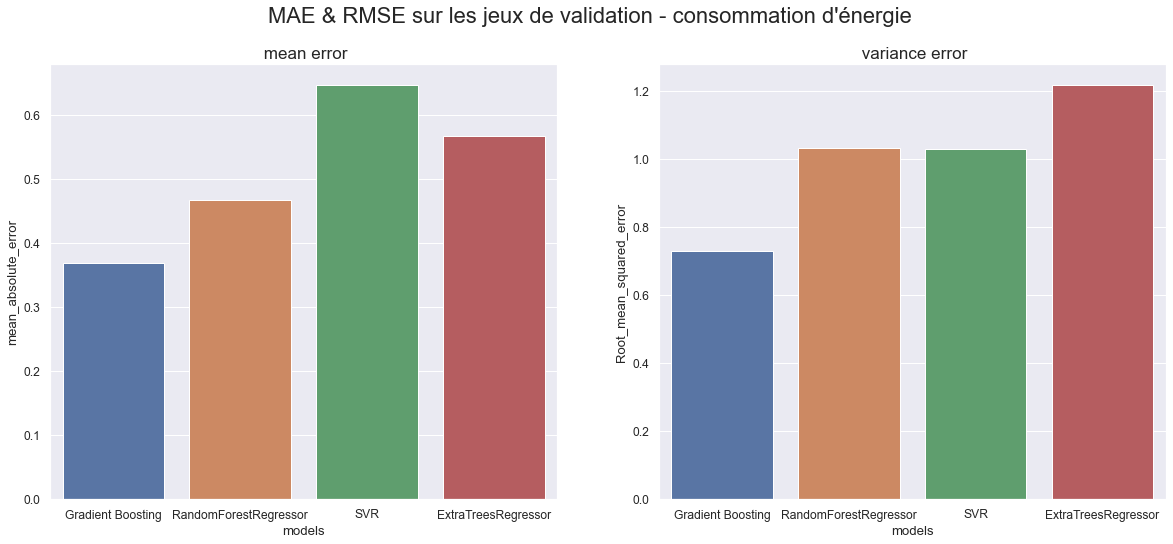

In [167]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,8))
plt.suptitle("MAE & RMSE sur les jeux de validation - consommation d'énergie",fontsize=22)
plt.subplot(1,2,1)
sns.barplot(x= df1['models'] ,y=df1['mean_absolute_error'])
plt.title(" mean error", fontsize=17)

plt.subplot(1,2,2)
sns.barplot(x= df1['models'] ,y=df1['Root_mean_squared_error'])
plt.title(" variance error", fontsize=17)

Avec la projection graphique ci-dessus, c'est bien clair que le modèle Gradient Boosting offre le meilleur résultat en score. 

Text(0.5, 1.0, 'std_fit_time')

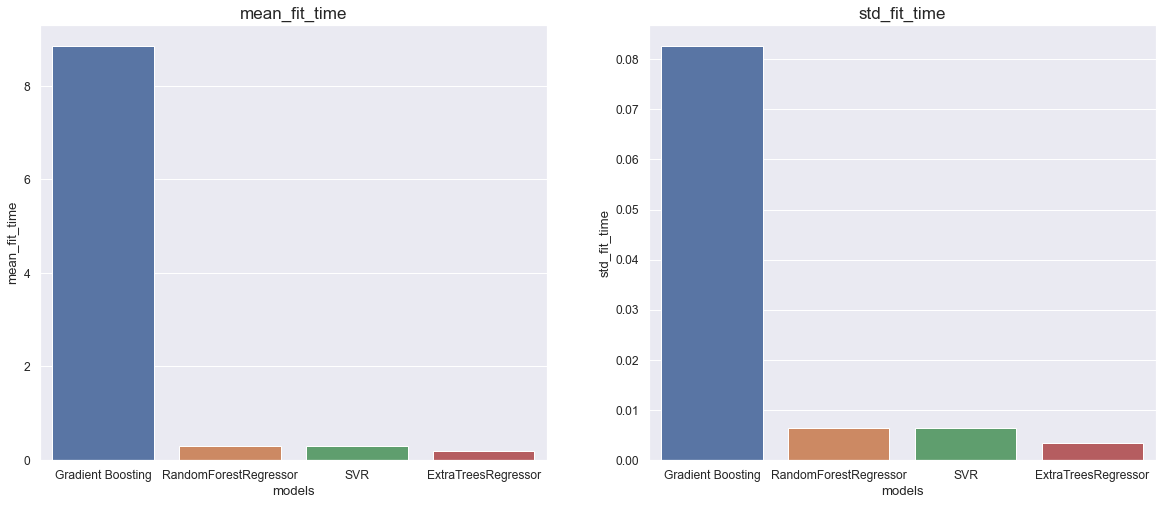

In [41]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(x= df1['models'] ,y=df1['mean_fit_time'])
plt.title("mean_fit_time", fontsize=17)
plt.subplot(1,2,2)
sns.barplot(x= df1['models'] ,y=df1['std_fit_time'])
plt.title("std_fit_time", fontsize=17)

Après avoir testé les premiers paramètres, nous avons à présent défini notre modèle pour la prédiction des émissions d'energy. Regardons à présent l'importance des variables dans notre modèle de Gradient Boosting:


#### Feature_importance SiteEnergyUse

In [109]:
feature_importances= GBR_energy.named_steps['model'].feature_importances_
feature_importances

array([7.31451910e-04, 3.54362549e-02, 1.04274133e-01, 2.47916000e-02,
       1.66274092e-02, 3.51298540e-01, 2.55683194e-03, 1.73907182e-01,
       7.80285513e-02, 8.00006177e-02, 3.88552041e-04, 1.76807846e-03,
       5.52280976e-04, 2.09524221e-02, 7.92832998e-04, 6.36080155e-03,
       2.84773286e-03, 4.06833669e-04, 8.16747550e-03, 2.17585149e-03,
       2.23659654e-04, 1.17109958e-04, 2.06676681e-03, 8.38207386e-03,
       1.29668140e-03, 1.26925631e-03, 1.05000640e-03, 1.10050243e-02,
       5.34305697e-04, 8.90236965e-04, 1.16838546e-02, 2.33693526e-02,
       5.25207573e-03, 9.90292851e-04, 6.36183159e-03, 5.67012600e-04,
       9.40408460e-04, 4.69192242e-04, 3.55901679e-03, 8.93195704e-04,
       1.03954394e-03, 2.26047984e-03, 6.27892919e-04, 1.57348383e-03,
       5.84440537e-04, 9.27370610e-04])

In [43]:
ohe_feature_nemes= GBR_energy['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)


In [44]:
ohe_feature_nemes

array(['BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_College/University',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery Store',
       'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Fa

In [45]:
numeric_features_names= np.concatenate([numeric_features,numeric_log_features])
numeric_features_names

array(['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore',
       'BuildingAge', 'PropertyGFAParking', 'PropertyGFABuilding',
       'Steam%', 'Electricity%', 'NaturalGas%', 'OtherEnergies%'],
      dtype='<U19')

In [46]:
feature_importances_names= np.concatenate([numeric_features_names,ohe_feature_nemes,])
feature_importances_names.shape

(46,)

In [47]:
# zip coeff & names together and make  DataFrame
zipped= zip(feature_importances_names,feature_importances)
df= pd.DataFrame(zipped, columns=['feature','importances'])
df

,feature,importances
0,NumberofBuildings,0.000731
1,NumberofFloors,0.035436
2,ENERGYSTARScore,0.104274
3,BuildingAge,0.024792
4,PropertyGFAParking,0.016627
5,PropertyGFABuilding,0.351299
6,Steam%,0.002557
7,Electricity%,0.173907
8,NaturalGas%,0.078029
9,OtherEnergies%,0.080001


In [48]:
df.keys()

Index(['feature', 'importances'], dtype='object')

<AxesSubplot:xlabel='importances', ylabel='feature'>

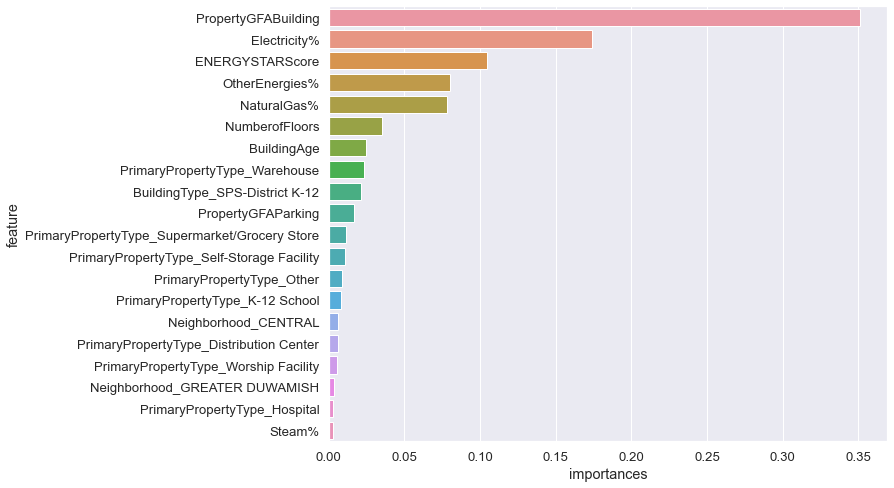

In [49]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,8))
sns.barplot(y='feature', x='importances', data= df.sort_values(by= 'importances', ascending = False).head(20))

### "TotalGHGEmissions"

In [50]:
# split "SiteEnergyUse" et "TotalGHGEmissions" into train test sets
X= data.drop(columns=['TotalGHGEmissions','SiteEnergyUse'], axis=1)

y_co2= data['TotalGHGEmissions']

X_train, X_test, y_train_co2, y_test_co2 = train_test_split(X,y_co2, test_size=0.2, random_state=34)

# traitement des variables discrete 
numeric_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['PropertyGFAParking','PropertyGFABuilding','Steam%','Electricity%',
                        'NaturalGas%', 'OtherEnergies%']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('num_log', numeric_log_transformer, numeric_log_features),
                                               ('cat', categorical_transformer, categorical_features)])

#Pipeline
pip = Pipeline(steps=[('preprocessor', preprocessor)])

pip.fit(X_train, y_train_co2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'ENERGYSTARScore',
                                                   'BuildingAge']),
                                                 ('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding',
                                                   'Steam%', 'Electricity%',
                                                   'NaturalGas%',
                                                   'OtherEnergies%']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood'])]))])

### GridSearch

### RandomForestRegressor

In [112]:
# RandomForestRegressor
pipe_RFR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(RandomForestRegressor()))])

grid_RFR = { 'preprocessor__num_log__log__func':[None,np.log1p],
             'model__regressor__max_features' : ['sqrt', 'log2'],
             'model__regressor__n_estimators':[100, 250],
             'model__regressor__max_depth':[5, 10, 15],
             'model__regressor__min_samples_split': [2, 5, 10],
             'model__regressor__bootstrap' : [True, False],
             'model__regressor__min_samples_leaf': [1,2,5],
             'model__regressor__n_jobs': [-1]}

grid_RFR = GridSearchCV( pipe_RFR, grid_RFR,cv=4, verbose=5)
grid_RFR.fit(X_train, y_train_co2)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=Tru

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__re

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__b

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__r

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor_

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bo

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__bo

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__r

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, mo

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor_

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.6s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.7s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, mo

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regresso

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, mode

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, mode

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor_

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=5, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regre

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regres

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__boot

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regress

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=False

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regre

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regres

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, m

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=10, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__boot

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.6s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=2, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regress

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=5, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__bootstr

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=10, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=2, model__regressor__n_estimators=100, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regre

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_depth=15, model__regressor__max_features=log2, model__regressor__min_samples_leaf=5, model__regressor__min_samples_split=5, model__regressor__n_estimators=250, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, m

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
             param_grid={'model__regressor__bootstrap': [True, False],
                         'model__regressor__max_depth': [5, 10, 15],
                         'model__regressor__max_features': ['sqrt', 'log2'],
                         'model__regressor__min_samples_leaf': [1, 2, 5],
                         'model__regressor__min_samples_split': [2, 5, 10],
                         'model__regressor__n_estimators': [100, 250],
                         'model__regressor__n_jobs': [-1],
                         'preprocessor__num_log__log__func': [None,
                                                              <ufunc 'log1p'>]},
             verbose=5)

In [113]:
grid_RFR.best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_depth': 15,
 'model__regressor__max_features': 'sqrt',
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 2,
 'model__regressor__n_estimators': 250,
 'model__regressor__n_jobs': -1,
 'preprocessor__num_log__log__func': None}

In [114]:
# RandomForestRegressor best params
RFR_co2 = Pipeline(steps=[('preprocessor', preprocessor),
                ('model',TransformedTargetRegressor(regressor= RandomForestRegressor(bootstrap= False,
                  max_depth= 15, max_features= 'sqrt', min_samples_leaf= 1,min_samples_split= 2,
                  n_estimators = 250, n_jobs= -1  )))])

RFR_co2.fit(X_train, y_train_co2)
RFR_co2_Score = RFR_co2.score(X_test, y_test_co2)
RFR_co2_Score

0.8465728630317898

In [115]:
print("score d'entrainement = ",RFR_co2_Score,"\n")
y_pred_co2 = grid_RFR.predict(X_test)
MAE_RFR= mean_absolute_error(y_test_co2,y_pred_co2)
RMSE_RFR = np.sqrt(mean_squared_error(y_test_co2,y_pred_co2))
mae_RFR = median_absolute_error(y_test_co2,y_pred_co2)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_RFR)
print("RMSE = ",RMSE_RFR)
print("median abs err = ",mae_RFR)

score d'entrainement =  0.8465728630317898 

score de la prédiction:
MAE =  0.38932410460918976
RMSE =  0.580129302098642
median abs err =  0.27628892350638234


In [116]:
# Temp d'entrainement du modèle
best_model_index = grid_RFR.best_index_
    
gs_RFR_mean_time= grid_RFR.cv_results_['mean_fit_time'][best_model_index]
gs_RFR_std_time= grid_RFR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_RFR_mean_time)
print("std_time = ",gs_RFR_std_time)

mean_time =  0.7523581385612488
std_time =  0.03130197279113818


#### GradientBoostingRegressor

In [117]:
# GradientBoostingRegressor
pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(GradientBoostingRegressor())),
                                         ])
   
grid_gbr = [{'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[np.log],
             'model__inverse_func':[np.exp],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]},
            {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[None],
             'model__inverse_func':[None],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]}
            ]

gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=4,
                      verbose=5)

gs_gbr.fit(X_train, y_train_co2)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model_

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<uf

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inver

[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   5.7s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   5.8s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   5.5s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__reg

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   7.1s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   7.5s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   8.9s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   9.1s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.7s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   6.1s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   7.7s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   7.8s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   9.1s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   5.8s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max

[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   7.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   9.1s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   9.1s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   8.7s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regress

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                                               <ufunc 'log1p'>]},
                         {'model__func': [None], 'model__inverse_func': [None],
                          'model__regressor__learning_rate': [0.16, 0.18, 0.2],
                          'model__regressor__max_depth': [4],
                          'model__regressor__n_estimators': array([1200, 1500, 1800]),
                          'model__regressor__random_state': [1],
                          'model__regressor__subsample': [0.7, 0.8, 0.9],
                          'preprocessor__num_log__log__func': [None,
                                                               <ufunc 'log1p'>]}],
             verbose=5)

In [118]:
gs_gbr.best_params_

{'model__func': None,
 'model__inverse_func': None,
 'model__regressor__learning_rate': 0.16,
 'model__regressor__max_depth': 4,
 'model__regressor__n_estimators': 1500,
 'model__regressor__random_state': 1,
 'model__regressor__subsample': 0.9,
 'preprocessor__num_log__log__func': None}

#### GradientBoostingRegressor best parameters

In [119]:
# GradientBoostingRegressor best params
GBR_co2= Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', GradientBoostingRegressor(n_estimators=1500, learning_rate=0.16,
                                      max_depth=4, subsample=0.9, random_state= 1))])

GBR_co2_fit= GBR_co2.fit(X_train, y_train_co2)
GBR_co2_Score= GBR_co2.score(X_test, y_test_co2)
GBR_co2_Score

0.8845839836494452

In [120]:
print("score d'entrainement = ",GBR_co2_Score,"\n")
y_pred_co2 = gs_gbr.predict(X_test)
MAE_gbr= mean_absolute_error(y_test_co2,y_pred_co2)
RMSE_gbr = np.sqrt(mean_squared_error(y_test_co2,y_pred_co2))
mae_gbr = median_absolute_error(y_test_co2,y_pred_co2)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_gbr)
print("RMSE = ",RMSE_gbr)
print("median abs err = ",mae_gbr)

score d'entrainement =  0.8845839836494452 

score de la prédiction:
MAE =  0.32740398908728185
RMSE =  0.5019537271043957
median abs err =  0.2205582886677373


In [121]:
# Temp d'entrainement du modèle
best_model_index = gs_gbr.best_index_
    
gs_gbr_mean_time= gs_gbr.cv_results_['mean_fit_time'][best_model_index]
gs_gbr_std_time= gs_gbr.cv_results_['std_fit_time'][best_model_index]
print(gs_gbr_mean_time, "\n", gs_gbr_std_time)

7.875119090080261 
 0.28166831651624785


### SVR

In [122]:
# Seprate Vector Regression
pipe_SVR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(SVR())) ])
   
grid_SVR = [{ 'preprocessor__num_log__log__func':[None,np.log1p],
              
              'model__regressor__C' : range(100,5000,1000),
              'model__regressor__epsilon' : [1,2],
              'model__regressor__kernel':['poly','rbf'],
              'model__regressor__gamma' : ['auto', 'scale'],
              'model__regressor__degree' : [3, 5]
                }]

GS_SVR = GridSearchCV(pipe_SVR, grid_SVR, cv=4, verbose=5)
GS_SVR.fit(X_train, y_train_co2)

Fitting 4 folds for each of 160 candidates, totalling 640 fits
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regresso

[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kerne

[CV 3/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=sca

[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=100, model__regressor__degree=5, model__regressor__epsilon=2, model__regres

[CV 4/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=3, model__regressor__epsilon=1, model__regr

[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=auto, mod

[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=1100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__

[CV 1/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   1.2s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.6s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.9s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=scale, model__re

[CV 4/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, m

[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=2100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regress

[CV 1/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__

[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamm

[CV 3/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.1s
[CV 4/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__ga

[CV 4/4] END model__regressor__C=3100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=1, model__regressor__gamma=auto, mod

[CV 2/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__regressor__kernel=rbf, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=3, model__regressor__epsilon=2, model__regressor__gamma=auto, model__

[CV 1/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=1, model__regressor__gamma=scale, model__re

[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=poly, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__gamma=scale, model__regressor__kernel=rbf, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__C=4100, model__regressor__degree=5, model__regressor__epsilon=2, model__regressor__ga

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                                                          'Neighborhood'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=SVR()))]),
             param_grid=[{'model__regressor__C': range(100, 5000, 1000),
                          'model__regressor__degree': [3, 5],
                          'model__regressor__epsilon': [1, 2],
                          'model__regressor__gamma': ['auto', 'scale'],
                          'model__regressor__kernel': ['poly', 'rbf'],
                          'preprocessor__num_log__log__func': [None,
                                                               <ufunc 'log1p'>]}],
             verbose=5)

In [123]:
GS_SVR.best_params_

{'model__regressor__C': 100,
 'model__regressor__degree': 3,
 'model__regressor__epsilon': 1,
 'model__regressor__gamma': 'auto',
 'model__regressor__kernel': 'rbf',
 'preprocessor__num_log__log__func': None}

In [124]:
# SVR best params
SVR_co2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(SVR(C=100, degree=3, epsilon=1, gamma= 'auto',
                                                                   kernel= 'rbf'))) ])

SVR_co2.fit(X_train, y_train_co2)
SVR_co2_Score = SVR_co2.score(X_test, y_test_co2)
SVR_co2_Score

0.771863792882615

In [125]:
print("score d'entrainement = ",SVR_co2_Score,"\n")
y_pred_co2 = SVR_co2.predict(X_test)
MAE_SVR= mean_absolute_error(y_test_co2,y_pred_co2)
RMSE_SVR = np.sqrt(mean_squared_error(y_test_co2,y_pred_co2))
mae_SVR = median_absolute_error(y_test_co2,y_pred_co2)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_SVR)
print("RMSE = ",RMSE_SVR)
print("median abs err = ",mae_SVR)

score d'entrainement =  0.771863792882615 

score de la prédiction:
MAE =  0.5218873888541207
RMSE =  0.7057124051214195
median abs err =  0.43610084222674605


In [126]:
# Temp d'entrainement du modèle
best_model_index = GS_SVR.best_index_
    
gs_SVR_mean_time= GS_SVR.cv_results_['mean_fit_time'][best_model_index]
gs_SVR_std_time= GS_SVR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_SVR_mean_time)
print("std_time = ",gs_SVR_std_time)

mean_time =  0.09475100040435791
std_time =  0.0035334979026380923


### ExtraTreesRegressor

In [129]:
# ExtraTreesRegressor
pipe_ETR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(ExtraTreesRegressor())) ])
   
grid_ETR = [{
            'preprocessor__num_log__log__func':[None],
            'model__regressor__n_estimators' :range(1,100,10),
            'model__regressor__min_samples_split': [2, 4],
            'model__regressor__min_samples_leaf': [2, 4],
            'model__regressor__max_features': ['sqrt', 'log2'],
            'model__regressor__bootstrap': [False, True],
            'model__regressor__n_jobs': [None, -1]
                        }]

GS_ETR = GridSearchCV(pipe_ETR, grid_ETR, cv=4, verbose=5)

GS_ETR.fit(X_train, y_train_co2)

Fitting 4 folds for each of 320 candidates, totalling 1280 fits
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sq

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__m

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__m

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sample

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__m

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.5s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min

[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_s

[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 1/4] END model__regressor__bootstrap=False, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__m

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_s

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_sampl

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_s

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=31, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sampl

[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_s

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_sp

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=21, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=2, model__regressor__n_estimators=91, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=21, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=31, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples_split=4, model__regressor__n_estimators=61, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=2, model__regressor__min_samples

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=1, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_sp

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=41, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=71, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.3s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=2, model__regressor__n_estimators=81, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=11, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples

[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=51, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

[CV 4/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=81, model__regressor__n_jobs=-1, preprocessor__num_log__log__func=None; total time=   0.1s
[CV 1/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 2/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=4, model__regressor__n_estimators=91, model__regressor__n_jobs=None, preprocessor__num_log__log__func=None; total time=   0.2s
[CV 3/4] END model__regressor__bootstrap=True, model__regressor__max_features=log2, model__regressor__min_samples_leaf=4, model__regressor__min_sam

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'ENERGYSTARScore',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionT...
                                        TransformedTargetRegressor(regressor=ExtraTreesRegressor()))]),
             param_grid=[{'model__regressor__bootstrap': [False, True],
                          'model__regressor__max_features': ['sqrt', 'log2'],
                          'model__regressor__min_samples_leaf': [2, 4],
                          'model__regressor__min_samples_split': [2, 4],
                          'model__regressor__n_estimators': range(1, 100, 10),
                          'model__regressor__n_jobs': [None, -1],
                          'preprocessor__num_log__log__func': [None]}],
             verbose=5)

In [130]:
GS_ETR.best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_features': 'sqrt',
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 4,
 'model__regressor__n_estimators': 71,
 'model__regressor__n_jobs': -1,
 'preprocessor__num_log__log__func': None}

In [131]:
#ExtraTreesRegressor best params
ETR_co2= Pipeline(steps=[('preprocessor', preprocessor),
                              ('model_ExtraTrees_energy',ExtraTreesRegressor(n_estimators=71 ,min_samples_leaf= 2,
                                min_samples_split= 4, bootstrap= False , max_features = 'sqrt', n_jobs= None))])

ETR_co2_fit = ETR_co2.fit(X_train, y_train_co2)
ETR_co2_Score = ETR_co2.score(X_test, y_test_co2)
ETR_co2_Score

0.7873909588649761

In [132]:
print("score d'entrainement = ",ETR_co2_Score,"\n")
y_pred_co2 = ETR_co2.predict(X_test)
MAE_ETR= mean_absolute_error(y_test_co2,y_pred_co2)
RMSE_ETR = np.sqrt(mean_squared_error(y_test_co2,y_pred_co2))
mae_ETR = median_absolute_error(y_test_co2,y_pred_co2)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_ETR)
print("RMSE = ",RMSE_ETR)
print("median abs err = ",mae_ETR)

score d'entrainement =  0.7873909588649761 

score de la prédiction:
MAE =  0.4793584979492108
RMSE =  0.6812735178251977
median abs err =  0.3623368839523038


In [133]:
# Temp d'entrainement du modèle
best_model_index = GS_ETR.best_index_
    
gs_ETR_mean_time= GS_ETR.cv_results_['mean_fit_time'][best_model_index]
gs_ETR_std_time= GS_ETR.cv_results_['std_fit_time'][best_model_index]
print("mean_time = " ,gs_ETR_mean_time)
print("std_time = ",gs_ETR_std_time)

mean_time =  0.17716741561889648
std_time =  0.003693768389611859


In [160]:
model_df = {'models': ['Gradient Boosting', 'RandomForestRegressor', 'SVR', 'ExtraTreesRegressor'],
            'mean_absolute_error': [MAE_gbr, MAE_RFR, MAE_SVR,MAE_ETR ],
            'Root_mean_squared_error': [RMSE_gbr, RMSE_RFR, RMSE_SVR, RMSE_ETR],
            'mean_fit_time':[gs_gbr_mean_time, gs_RFR_mean_time,gs_RFR_mean_time, gs_ETR_mean_time] ,
            'std_fit_time': [gs_gbr_std_time,gs_RFR_std_time, gs_RFR_std_time,gs_ETR_std_time ],
            'Score': [GBR_co2_Score,RFR_co2_Score, SVR_co2_Score, ETR_co2_Score]}
df2= pd.DataFrame(model_df)
df2

,models,mean_absolute_error,Root_mean_squared_error,mean_fit_time,std_fit_time,Score
0,Gradient Boosting,0.327404,0.501954,7.875119,0.281668,0.884584
1,RandomForestRegressor,0.389324,0.580129,0.752358,0.031302,0.846573
2,SVR,0.521887,0.705712,0.752358,0.031302,0.771864
3,ExtraTreesRegressor,0.479358,0.681274,0.177167,0.003694,0.787391


Text(0.5, 1.0, ' variance error')

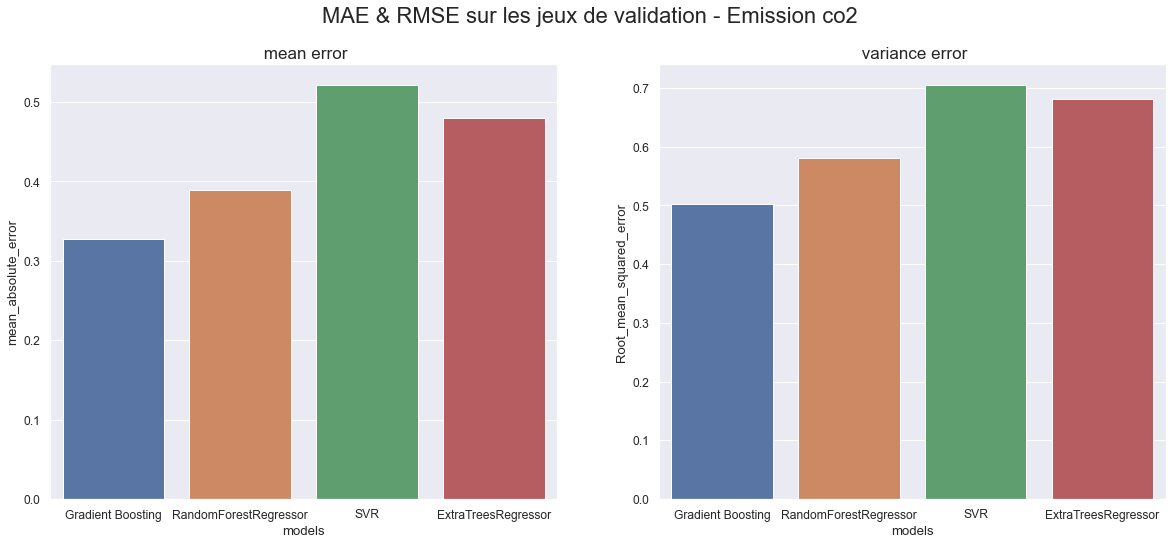

In [168]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,8))
plt.suptitle("MAE & RMSE sur les jeux de validation - Emission co2",fontsize=22)
plt.subplot(1,2,1)
sns.barplot(x= df2['models'] ,y=df2['mean_absolute_error'])
plt.title(" mean error", fontsize=17)
plt.subplot(1,2,2)
sns.barplot(x= df2['models'] ,y=df2['Root_mean_squared_error'])
plt.title(" variance error", fontsize=17)

<AxesSubplot:xlabel='models', ylabel='std_fit_time'>

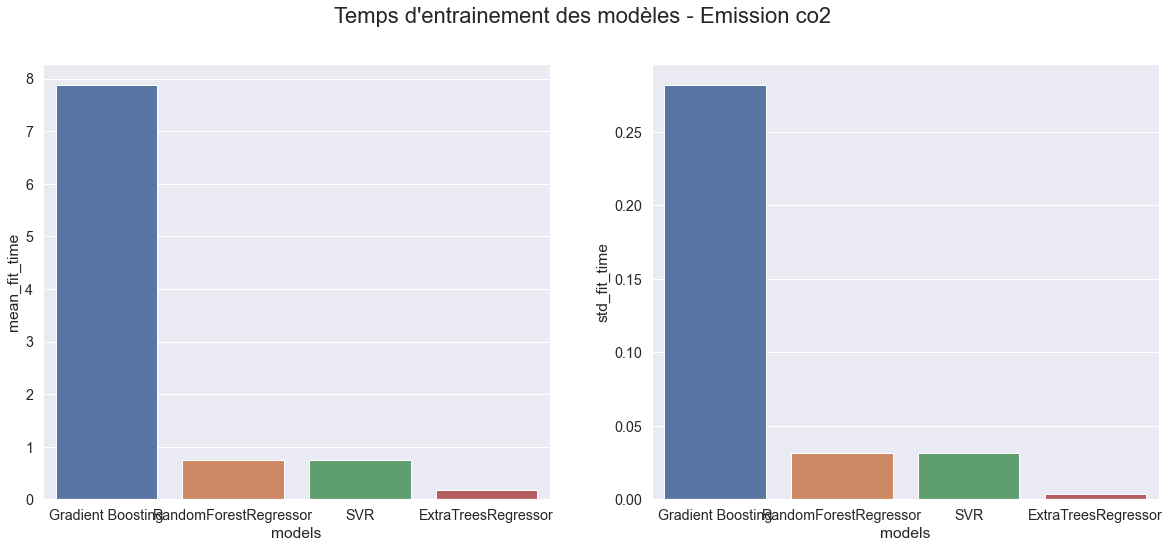

In [136]:
sns.set(font_scale=1.3)
plt.figure(figsize=(20,8))
plt.suptitle("Temps d'entrainement des modèles - Emission co2",fontsize=22)
plt.subplot(1,2,1)
sns.barplot(x= df2['models'] ,y=df2['mean_fit_time'])

plt.subplot(1,2,2)
sns.barplot(x= df2['models'] ,y=df2['std_fit_time'])

Avec la projection graphique, c'est bien clair que le modèle Gradient boosting offre le meilleur résultat en erreur score. 

Après avoir testé les paramètres, nous avons à présent défini notre modèle pour la prédiction des émissions de CO2. Regardons à présent l'importance des variables dans notre modèle de Gradient Boosting:

### Feature_importance co2

In [143]:
feature_importances_co2= GBR_co2.named_steps['model'].feature_importances_
feature_importances_co2

array([1.13185431e-03, 1.34780725e-02, 5.08951817e-02, 2.06824360e-02,
       2.56297704e-02, 4.08456891e-01, 1.09251771e-02, 2.89903226e-01,
       2.97487325e-02, 3.44878592e-02, 7.73947045e-04, 6.23623110e-04,
       1.86225591e-03, 2.59754190e-03, 6.73544600e-04, 7.70362047e-03,
       3.18974685e-03, 5.95200631e-04, 1.15367720e-03, 3.02338922e-03,
       4.23726366e-04, 8.71650646e-05, 2.41105763e-03, 7.49784114e-03,
       1.17125337e-03, 1.18906625e-03, 1.53087515e-03, 1.26375082e-02,
       1.14577513e-03, 1.11402023e-03, 1.47761307e-02, 2.66730494e-02,
       5.78522221e-03, 1.33466489e-03, 1.03355311e-03, 5.40679951e-04,
       1.24085288e-03, 1.03346070e-03, 3.94729922e-03, 9.18024417e-04,
       1.55341538e-03, 1.10451532e-03, 5.95687976e-04, 1.10801443e-03,
       5.78565612e-04, 1.03282737e-03])

In [138]:
onehot_columns = list(GBR_co2.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(numeric_log_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list

['NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'BuildingAge',
 'PropertyGFAParking',
 'PropertyGFABuilding',
 'Steam%',
 'Electricity%',
 'NaturalGas%',
 'OtherEnergies%',
 'BuildingType_Campus',
 'BuildingType_NonResidential',
 'BuildingType_Nonresidential COS',
 'BuildingType_SPS-District K-12',
 'PrimaryPropertyType_College/University',
 'PrimaryPropertyType_Distribution Center',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Large Office',
 'PrimaryPropertyType_Medical Office',
 'PrimaryPropertyType_Mixed Use Property',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Refrigerated Warehouse',
 'PrimaryPropertyType_Restaurant',
 'PrimaryPropertyType_Retail Store',
 'PrimaryPropertyType_Self-Storage Facility',
 'PrimaryPropertyType_Senior Care Community',
 'PrimaryPropertyType_Small- and Mid-Sized Office',
 'PrimaryPropertyType_Supermarket/Grocery Store',
 'P

In [139]:
# traitement des variables discrete 
"""numeric_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['PropertyGFAParking','PropertyGFABuilding','Steam%','Electricity%',
                        'NaturalGas%', 'OtherEnergies%']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('num_log', numeric_log_transformer, numeric_log_features),
                                               ('cat', categorical_transformer, categorical_features)])"""

"numeric_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore','BuildingAge']\nnumeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\n                                      ('scaler', StandardScaler())])\n\n# traitement des variables continues : imputation par médiane + log + standardcaler\nnumeric_log_features = ['PropertyGFAParking','PropertyGFABuilding','Steam%','Electricity%',\n                        'NaturalGas%', 'OtherEnergies%']\nnumeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\n                                          ('log', FunctionTransformer()),\n                                          ('scaler', StandardScaler())])\n\ncategorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']\ncategorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),\n                                          ('onehot', OneHotEncoder(handle_unknow

In [140]:
X_test.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding,ENERGYSTARScore,BuildingAge,Steam%,Electricity%,NaturalGas%,OtherEnergies%
1779,SPS-District K-12,K-12 School,LAKE UNION,1.0,4.0,0,241066,79.0,19,0.0,39.737334,60.262666,0.000000
2071,NonResidential,Mixed Use Property,GREATER DUWAMISH,1.0,3.0,0,56700,37.0,106,0.0,86.247156,13.752844,0.000000
1037,NonResidential,Warehouse,MAGNOLIA / QUEEN ANNE,1.0,2.0,0,39497,8.0,60,0.0,76.070681,23.932494,-0.003175
2004,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,1.0,1.0,0,53250,96.0,52,0.0,58.420491,41.579495,0.000014
2421,NonResidential,Warehouse,GREATER DUWAMISH,1.0,1.0,0,27680,NaN,48,0.0,36.122837,63.877177,-0.000014


In [141]:
pip= Pipeline(steps=[('preprocessor', preprocessor)])
# pour s'assurer que ça marche, on voit bien que les données ont été transformées, donc le step du preprocessor marche
pd.DataFrame.sparse.from_spmatrix(pip['preprocessor'].transform(X_test)).head(5)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.068398,-0.021942,0.478590,-1.060356,-0.310673,0.806312,-0.234155,-1.177855,1.263946,-0.044316,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.068398,-0.171240,-1.305621,1.585539,-0.310673,-0.252565,-0.234155,0.609325,-0.519854,-0.044316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.068398,-0.320537,-2.537576,0.186560,-0.310673,-0.351368,-0.234155,0.218285,-0.129432,-0.045330,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.068398,-0.469835,1.200771,-0.056741,-0.310673,-0.272380,-0.234155,-0.459939,0.547387,-0.044312,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.068398,-0.469835,0.223703,-0.178391,-0.310673,-0.419237,-0.234155,-1.316745,1.402574,-0.044321,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
# zip coeff & names together and make  DataFrame
zipped= zip(numeric_features_list,feature_importances_co2)
df2= pd.DataFrame(zipped, columns=['feature','importances'])
df2

,feature,importances
0,NumberofBuildings,0.001132
1,NumberofFloors,0.013478
2,ENERGYSTARScore,0.050895
3,BuildingAge,0.020682
4,PropertyGFAParking,0.025630
5,PropertyGFABuilding,0.408457
6,Steam%,0.010925
7,Electricity%,0.289903
8,NaturalGas%,0.029749
9,OtherEnergies%,0.034488


<AxesSubplot:xlabel='importances', ylabel='feature'>

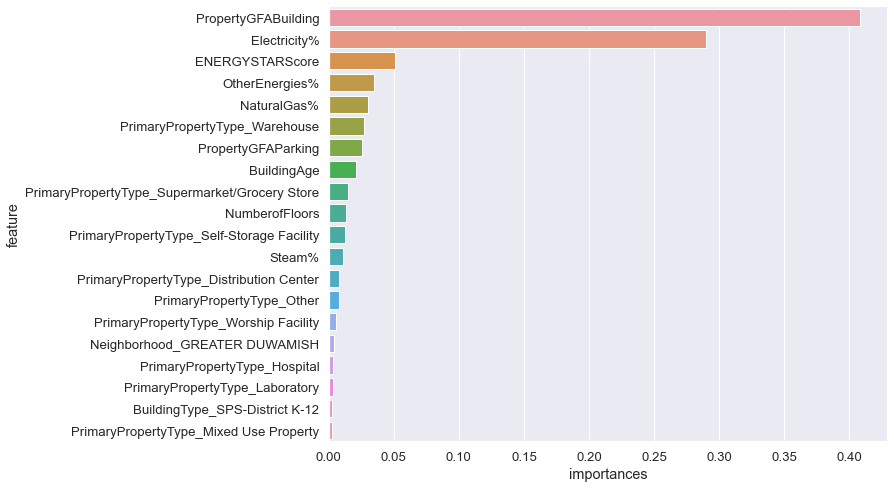

In [146]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,8))
sns.barplot(y='feature', x='importances', data= df2.sort_values(by= 'importances', ascending = False).head(20))

### Influence de l'ENERGYSTARScore
 
L'Energy Star Score est un score entre 1 et 100 qui reflètent l'efficacité énergétique d'un bâtiment parmi les bâtiments similaires déjà certifiés. Un score de 50 signifie qu'il est dans la médiane alors qu'un score au-dessus de 75 indique qu'il s'agit d'un bâtiment à haute performance.



In [164]:
# split "SiteEnergyUse" et "SiteEnergyUse" into train test sets

X_score= data.drop(columns=['TotalGHGEmissions','SiteEnergyUse','ENERGYSTARScore'], axis=1)

y_score= data['TotalGHGEmissions']

X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(X_score,y_score, test_size=0.2, random_state=34)

# traitement des variables discrete 
numeric_features = ['PropertyGFAParking','PropertyGFABuilding','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['NumberofBuildings', 'NumberofFloors','Steam%','Electricity%',
                        'NaturalGas%', 'OtherEnergies%']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('num_log', numeric_log_transformer, numeric_log_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_score_train,y_score_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['PropertyGFAParking', 'PropertyGFABuilding',
                                  'BuildingAge']),
                                ('num_log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log', FunctionTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'Steam%', 'Electricity%', 'NaturalGas%',
                                  'OtherEnergies%']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood'])])

In [165]:
# GradientBoostingRegressor
pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(GradientBoostingRegressor())),
                                         ])
   
grid_gbr = [{'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[np.log],
             'model__inverse_func':[np.exp],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]},
            {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[None],
             'model__inverse_func':[None],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]}
            ]

gs_gb_sc = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=4,
                      verbose=5)

gs_gb_sc.fit(X_score_train,y_score_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model_

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__in

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__reg

[CV 1/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/4] END model__func=<ufunc 'log'>, model__inver

[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   6.8s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   6.5s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   6.8s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__reg

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   7.7s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   8.2s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   5.5s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   5.4s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   7.1s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   7.2s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__m

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   9.0s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   8.6s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4,

[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   6.2s
[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   7.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

[CV 4/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   8.5s
[CV 1/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/4] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PropertyGFAParking',
                                                                          'PropertyGFABuilding',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer()...
                                                               <ufunc 'log1p'>]},
                         {'model__func': [None], 'model__inverse_func': [None],
                          'model__regressor__learning_rate': [0.16, 0.18, 0.2],
                          'model__regressor__max_depth': [4],
                          'model__regressor__n_estimators': array([1200, 1500, 1800]),
                          'model__regressor__random_state': [1],
                          'model__regressor__subsample': [0.7, 0.8, 0.9],
                          'preprocessor__num_log__log__func': [None,
                                                               <ufunc 'log1p'>]}],
             verbose=5)

In [170]:
gs_gb_sc.best_params_

{'model__func': None,
 'model__inverse_func': None,
 'model__regressor__learning_rate': 0.16,
 'model__regressor__max_depth': 4,
 'model__regressor__n_estimators': 1500,
 'model__regressor__random_state': 1,
 'model__regressor__subsample': 0.9,
 'preprocessor__num_log__log__func': None}

In [171]:
GBR_score = Pipeline(steps=[('preprocessor', preprocessor),
                ('model', GradientBoostingRegressor(n_estimators=1500, learning_rate=0.16,
                                      max_depth=4, subsample=0.9, random_state= 1))])
GBR_score_fit= GBR_score.fit(X_score_train,y_score_train)
GBR_score_score= GBR_score.score(X_score_test, y_score_test)

In [172]:
print("score d'entrainement = ",GBR_score_score,"\n")
y_pred_en_sc = gs_gb_sc.predict(X_score_test)
MAE_en_sc= mean_absolute_error(y_score_test,y_pred_en_sc)
RMSE_en_sc = mean_squared_error(y_score_test,y_pred_en_sc, squared= False)


print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_en_sc)
print("RMSE = ",RMSE_en_sc)

score d'entrainement =  0.8661835881389129 

score de la prédiction:
MAE =  0.36441461317797036
RMSE =  0.5404871006008556


In [175]:
model_df_en_sc = {'Emission CO2': ['Emission CO AVEC Energy Score', 'Emission CO2 SANS Energy Score'],
                 'mean_absolute_error': [MAE_gbr, MAE_en_sc],
                 'Root_mean_squared_error': [RMSE_gbr, RMSE_en_sc],
                 'Score': [GBR_co2_Score,GBR_score_score]}
df3= pd.DataFrame(model_df_en_sc)
df3

,Emission CO2,mean_absolute_error,Root_mean_squared_error,Score
0,Emission CO AVEC Energy Score,0.327404,0.501954,0.884584
1,Emission CO2 SANS Energy Score,0.364415,0.540487,0.866184


Text(0.5, 1.0, ' variance error')

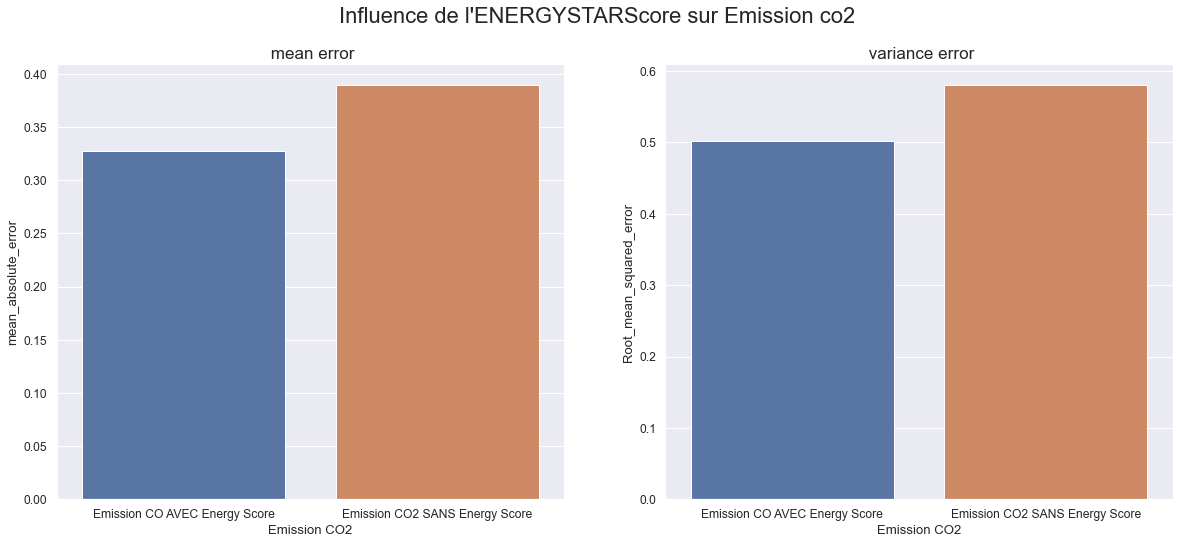

In [178]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,8))
plt.suptitle("Influence de l'ENERGYSTARScore sur Emission co2",fontsize=22)
plt.subplot(1,2,1)
sns.barplot(x= df3['Emission CO2'] ,y=df2['mean_absolute_error'])
plt.title(" mean error", fontsize=17)
plt.subplot(1,2,2)
sns.barplot(x= df3['Emission CO2'] ,y=df2['Root_mean_squared_error'])
plt.title(" variance error", fontsize=17)